<center>
<b>EC4.403: Robotics: Planning and Navigation</b> <br>
<b>Spring 2021</b> <br>
<b>Assignment-1 </b>
</center>

<div style="text-align: right"><b>Team:</b> Makkhi-2 (2018102023, 2018111003)</div>

# Import libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance

# Create grid image

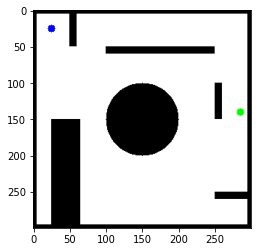

An image of our world.
Blue dot represents start node,
Green dot represents goal node,
Black regions represent obstacles
White regions represent empty spaces



In [2]:
def addRectangle(image,x0,y0,height,width):
    '''Function to add rectangular obstacles to our world. Note that (0,0) corresponds to the top left corner
    of the image'''
    image[y0:y0+height,x0:x0+width,:]=0
    return image

def addCircle(image,center_x, center_y,radius,colour=(0,0,0),thickness=-1):
    '''Function to add circular obstacles to our world. Note that (0,0) corresponds to the top left corner
    of the image'''
    return cv2.circle(image,(center_x,center_y),radius,colour,thickness)

def addBorders(world,border_thickness=5):
    world[:,:border_thickness,:]=0 # Left border
    world[:border_thickness,:,:]=0 # Top border
    world[:,-border_thickness:,:]=0 # Right border
    world[-border_thickness:,:,:]=0 # Bottom border
    return world

def createWorld(height,width,robot_initial_point,robot_final_point):
    '''Function to make the world/occupancy grid.'''
    # Create an empty space of size heightxwidth
    world=np.uint8(np.full((height,width,3),255))
    
    # Add borders to our empty space
    world=addBorders(world)

    # Add rectangular obstacles to the world
    world=addRectangle(world,x0=25,y0=150,height=150,width=40)
    world=addRectangle(world,x0=250,y0=100,height=50,width=10)
    world=addRectangle(world,x0=250,y0=250,height=10,width=50)
    world=addRectangle(world,x0=100,y0=50,height=10,width=150)
    world=addRectangle(world,x0=50,y0=0,height=50,width=10)
    
    # Add circular obstacles to the world    
    world=addCircle(center_x=150,center_y=150,radius=50,image=world)
    
    # Mark start and end points on the world
    world=addCircle(image=world,center_x=robot_initial_point[0],center_y=robot_initial_point[1],\
                    radius=5,colour=(0,0,255),thickness=-1) #Draw a blue circle representing start
    world=addCircle(image=world,center_x=robot_final_point[0],center_y=robot_final_point[1],\
                    radius=5,colour=(0,255,0),thickness=-1) #Draw a green circle representing goal

    '''The empty spaces in the world correspond to the points where world[i][j]=255 and obstacles correspond to 
    places where world[i][j]=0'''    
    
    return world

robot_initial_point=(25,25)
robot_final_point=(285,140)
img_obstacles=createWorld(300,300,robot_initial_point,robot_final_point)

plt.imshow(img_obstacles) # Visualize how are world looks like
plt.show()
print("An image of our world.\nBlue dot represents start node,\nGreen dot represents goal node,\n\
Black regions represent obstacles\nWhite regions represent empty spaces\n")

np_obs_points = np.array(np.where((img_obstacles == [0, 0, 0]).all(axis = 2))) # obstacle pixels indices present in the image
np_obs_points = np_obs_points.T
np_white_points = np.array(np.where((img_obstacles == [255, 255, 255]).all(axis = 2))) # white pixels indices present in the image
np_white_points = np_white_points.T
#cv2_imshow(img_obstacles)

There are 3 obstacles: 1 hollow triangle, 1 disc and 1 rectangle.

# Robot initialization

In [3]:
b = 12 
d = 5
v_f = 2
#robot_initial_point = (25, 25) # row, col ~ The coordinates are reversed here
robot_final_point = (140, 285) # row, col ~ The coordinates are reversed here

In [4]:
img_obstacles_mid = img_obstacles[:]

# Tree node

In [5]:
np_rrt_nodes = np.array([*robot_initial_point, 0, 0]).reshape(1, -1) # current_node_r, current_node_c, steer_angle, parent_index

# RRT

In [6]:
def compute_motion_primitive(np_path, steer_angle):
    i = 0 #initilizer
    step_size = 5
    np_path = np_path[:]
    np_path = np_path.reshape(1,-1)
    #back_coord = np.array([0, -b]) + np_path[0]
    #wheel_1_coord = np.array([d, 0]) + back_coord
    #wheel_2_coord = np.array([-d, 0]) + back_coord
    wheel_1_coord = np.array([d, 0]) + np.array([0, -b]) + np_path[0]
    wheel_2_coord = np.array([-d, 0]) + np.array([0, -b]) + np_path[0]
    w1 = np.array([*wheel_1_coord])
    w2 = np.array([*wheel_2_coord])
    np_path_wheel_1 = w1.reshape(1, -1)
    np_path_wheel_2 = w2.reshape(1, -1)
    
    while ( i < step_size ):
        y_comp = np.sin(steer_angle)
        x_comp = np.cos(steer_angle)
        y_vel = v_f * y_comp
        x_vel = v_f * x_comp
        
        path_y = np_path[i, 0]
        path_x = np_path[i, 1]
        temp = np.array([[path_y + y_vel, path_x + x_vel]])
        np_path = np.append(np_path, temp, axis = 0)

        #back_coord = np.array([0, -b]) + np_path[-1]
        #wheel_1_coord = np.array([d, 0]) + back_coord
        #wheel_2_coord = np.array([-d, 0]) + back_coord
        wheel_1_coord = np.array([d, 0]) + np.array([0, -b]) + np_path[-1]
        wheel_2_coord = np.array([-d, 0]) + np.array([0, -b]) + np_path[-1]
        w1 = np.array([[*wheel_1_coord]])
        w2 = np.array([[*wheel_2_coord]])
        np_path_wheel_1 = np.append(np_path_wheel_1, w1, axis = 0)
        np_path_wheel_2 = np.append(np_path_wheel_2, w2, axis = 0)
        i = i+1;
    return np_path, np_path_wheel_1, np_path_wheel_2

Random Tree Evolution


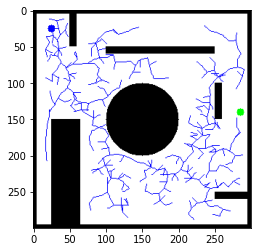

In [7]:
while True:
    start_rand = 0
    end_rand = len(np_white_points)
    random_index = np.random.randint(start_rand, end_rand)
    np_q_rand = np_white_points[random_index] # row, col
    
    p1 = [np_q_rand]
    p2 = np_rrt_nodes[:, :2]
    parent_index = distance.cdist(p1, p2).argmin()
    np_q_near = np_rrt_nodes[parent_index] # find the minimum distance among the points

    steer_angle = np.arctan2((np_q_rand - np_q_near[:2])[0], (np_q_rand - np_q_near[:2])[1]) # in radians
    np_path, np_path_wheel_1, np_path_wheel_2 = compute_motion_primitive(np_q_near[:2], steer_angle)
    np_path, np_path_wheel_1, np_path_wheel_2 = np.round(np_path), np.round(np_path_wheel_1), np.round(np_path_wheel_2)

    if (distance.cdist(np_path, np_obs_points).min() == 0):
        continue
    elif (distance.cdist(np_path_wheel_1, np_obs_points).min() == 0):
        continue
    elif (distance.cdist(np_path_wheel_2, np_obs_points).min() == 0):
        continue
    else:
        path_1 = np_path[-1, 0]
        path_2 = np_path[-1, 1]
        node_2 = np.array([path_1, path_2, steer_angle, parent_index]).reshape(1, -1)
        np_rrt_nodes = np.append(np_rrt_nodes, node_2, axis = 0)

        for i in range(len(np_path)-1):
            temp1 = tuple(np_path[i, :2].astype(np.int))[::-1]
            temp2 = tuple(np_path[i+1, :2].astype(np.int))[::-1]
            img_obstacles_mid = cv2.line(img_obstacles_mid, temp1, temp2, (0, 0, 255), 1)
        # cv2_imshow(img_obstacles_mid)
        
        tolarence = 10
        diff = robot_final_point - np_path[-1]
        if (np.linalg.norm(diff) <= tolarence): 
            break

plt.imshow(img_obstacles_mid)
print ("Random Tree Evolution")

# Trace the path

In [8]:
nodes_indices_to_travel = []
node_index = len(np_rrt_nodes) - 1
index = 0
while node_index:
    nodes_indices_to_travel.append(node_index)
    node_index = int(np_rrt_nodes[node_index, 3])
    index = index + 1;
nodes_indices_to_travel.append(node_index)
nodes_indices_to_travel = nodes_indices_to_travel[::-1]
img_obstacles_copy = img_obstacles_mid[:]

# Holonomic Paths traversed

Path Taken


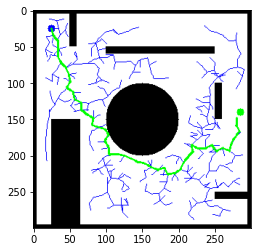

In [9]:
img_obstacles_copy = img_obstacles_mid[:]
#num = 1
for n in range(len(nodes_indices_to_travel)-1):
    path=np_rrt_nodes[nodes_indices_to_travel[n], :2]
    steer=np_rrt_nodes[nodes_indices_to_travel[n+1], 2]
    temp=compute_motion_primitive(path, steer)
    np_path, np_path_wheel_1, np_path_wheel_2 = temp[0], temp[1], temp[2]
    
    for i in range(len(np_path)-1):
        temp1 = tuple(np_path[i, :2].astype(np.int))[::-1]
        temp2 = tuple(np_path[i+1, :2].astype(np.int))[::-1]
        img_obstacles_copy = cv2.line(img_obstacles_copy, temp1, temp2, (0, 255, 0), 2)
    #img_str = "./h_reel/" + str(num) + ".png"
    #cv2.imwrite(img_str,img_obstacles_copy)
    #plt.imshow(img_obstacles_copy)
    #plt.show()
    #num = num + 1
print ("Path Taken")
plt.imshow(img_obstacles_copy)
plt.show()

Individual Wheel Trajectory


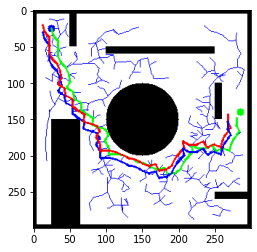

In [10]:
img_obstacles_3 = img_obstacles[:]
for n in range(len(nodes_indices_to_travel)-1):
    path=np_rrt_nodes[nodes_indices_to_travel[n], :2]
    steer=np_rrt_nodes[nodes_indices_to_travel[n+1], 2]
    temp=compute_motion_primitive(path, steer)
    np_path, np_path_wheel_1, np_path_wheel_2 = temp[0], temp[1], temp[2]
    for i in range(len(np_path)-1):
        temp1 = tuple(np_path[i, :2].astype(np.int))[::-1]
        temp2 = tuple(np_path[i+1, :2].astype(np.int))[::-1]
        img_obstacles_3 = cv2.line(img_obstacles_3, temp1, temp2, (0, 255, 0), 2)
        temp1 = tuple(np_path_wheel_1[i, :2].astype(np.int))[::-1]
        temp2 = tuple(np_path_wheel_1[i+1, :2].astype(np.int))[::-1]
        img_obstacles_3 = cv2.line(img_obstacles_3, temp1, temp2, (0, 0, 255), 2)
        temp1 = tuple(np_path_wheel_2[i, :2].astype(np.int))[::-1]
        temp2 = tuple(np_path_wheel_2[i+1, :2].astype(np.int))[::-1]
        img_obstacles_3 = cv2.line(img_obstacles_3, temp1, temp2, (255, 0, 0), 2)
    #img_str = "./h_reel/" + str(num) + ".png"
    #cv2.imwrite(img_str,img_obstacles_3)
    #plt.imshow(img_obstacles_3)
    #plt.show()
    #num = num + 1
print ("Individual Wheel Trajectory")
plt.imshow(img_obstacles_3)
plt.show()